## Final Project Submission

Please fill out:
* Student name: William Newton
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Amber Yandow
* Blog post URL: 


# Import Libraries #

In [156]:
# Your code here - remember to use markdown cells for comments as well!
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, scale
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.svm import SVC
from itertools import combinations
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')

# Function Engineering #

Defined quick_hist function to speed up normalization checks

In [2]:
def quick_hist(data,col):
    #plot quick histogram of relevant column
    plt.figure(figsize=(10,5))
    data[col].hist()

In [3]:
def make_heatmap(df,cols):
    # plot quick heatmap of correlation between different cols in a data set in order to check for multicollinearity
    plt.figure(figsize=(12,6))
    return sns.heatmap(df[cols].corr(),annot=True,cmap='coolwarm'),print(abs(df[cols].corr()>.75).sum())

In [4]:
def quick_scores(X_train, X_test, y_train, y_test, model=0):
    y_train_score = model.predict(X_train)
    train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)
    y_test_score = model.predict(X_test)
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(train_fpr, train_tpr, color='darkorange',
         lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve for Training Set')
    plt.legend(loc='lower right')
    print('Training AUC: {}'.format(auc(train_fpr, train_tpr)))
    plt.show()
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve for Test Set')
    plt.legend(loc='lower right')
    print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))
    print('')
    plt.show()
    print(confusion_matrix(y_test, y_test_score))
    print(classification_report(y_test, y_test_score))

In [5]:
def quick_bar(col):
    # quickly plot bar graphs that show total number of cases present in data set related to categorical columns
    # and the amount of those instances that churned in red
    df_col = df.groupby(col).sum()
    df_col1 = df.groupby(col).count()
    fig, ax = plt.subplots(figsize=(10,5))
    ax1 = sns.barplot(data = df_col1, x=df_col1.index, y='SeniorCitizen', color='blue', label='Total Cases')
    ax2 = sns.barplot(data=df_col, x=df_col.index, y='Churn', color='red', label='Total Churned')
    plt.title(col, size=15)
    plt.legend()
    plt.show()

In [6]:
def plot_feature_importances(model):
    # quickly plot the feature importance of features used in the model to be compared against each other
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')


# Import Data Set and Pre-Processing

Loaded Data Set into Jupyter Notebook and began by checking column data types

In [7]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [8]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [10]:
df.sort_values('TotalCharges')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6646,8249-THVEC,Male,0,Yes,Yes,51,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.40,997.75,No
5598,6051-PTVNS,Female,0,Yes,Yes,55,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic),19.15,998.1,No
3686,5899-MQZZL,Female,0,No,No,13,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,75.00,999.45,Yes
3353,4536-PLEQY,Male,0,Yes,No,12,Yes,No,Fiber optic,No,Yes,No,No,No,Yes,Month-to-month,Yes,Credit card (automatic),85.05,999.8,No


In [11]:
len(df.loc[df['TotalCharges'] == ' '])

11

Identified 11 rows with missing Total Charges. Deleted from data frame and changed row type to float

In [12]:
df=df.loc[df['TotalCharges'] != ' ']
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [13]:
df['TotalCharges']=df['TotalCharges'].astype('float')

Changed SeniorCitizen column to string and changed binary codes to Yes/No for dummies later. 

All columns appear to be correct data type now 

Dropped customerID column from data frame as it is not a predictive column

In [14]:
df['SeniorCitizen']=df['SeniorCitizen'].astype('str')

In [15]:
df['SeniorCitizen']=df['SeniorCitizen'].replace({'0': 'No', '1':'Yes'})

In [16]:
df['Churn']=df['Churn'].replace({'No': '0', 'Yes':'1'}).astype('int')

In [17]:
df=df.drop(columns='customerID', axis=1)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
gender              7032 non-null object
SeniorCitizen       7032 non-null object
Partner             7032 non-null object
Dependents          7032 non-null object
tenure              7032 non-null int64
PhoneService        7032 non-null object
MultipleLines       7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
Contract            7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
Churn               7032 non-null int64
dtypes: float64(2), int64(2), object(16)
memory usage: 1.1+ MB


# EDA #

Split out numerical and categorical data for further investigation.

In [19]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [20]:
numerical = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical = ['gender', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Plotted histograms of numerical columns to examine distributions. Log transformations may be necessary to increase normality

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2399a320>,
      dtype=object)

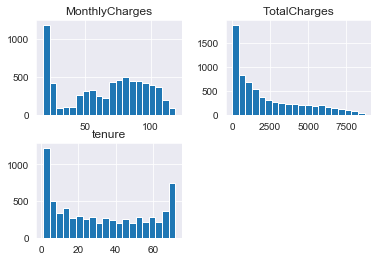

In [21]:
df[numerical].hist(bins=20)

Plotted box plots of numerical columns. No major outliers are detected except in the Total Charges column, which is to be expected when compared to tenure and Monthly Charges as they are on a much smaller scale. 

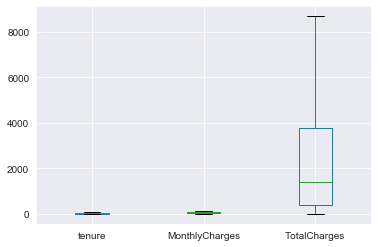

In [22]:
df[numerical].plot(kind='box')

Plotted histograms of numerical columns again with churn class plotted on same visualization. Will clean this up and use in non-technical presentation as it will probably be a good explainer for what are the biggest causes of churn

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a245904a8>,
      dtype=object)

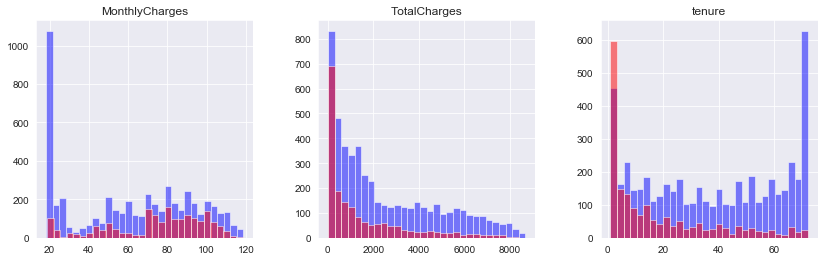

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
df[df.Churn == 0][numerical].hist(bins=30, color="blue", alpha=0.5, ax=ax)
df[df.Churn == 1][numerical].hist(bins=30, color="red", alpha=0.5, ax=ax)

Wrote function to quickly plot bar graphs for categorical features in the data frame. Blue represents total cases in data frame and red represents the amount of those cases that churned

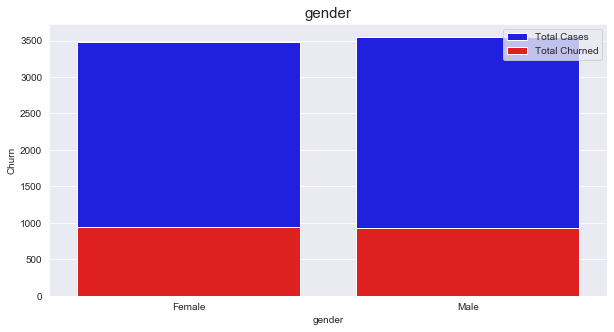

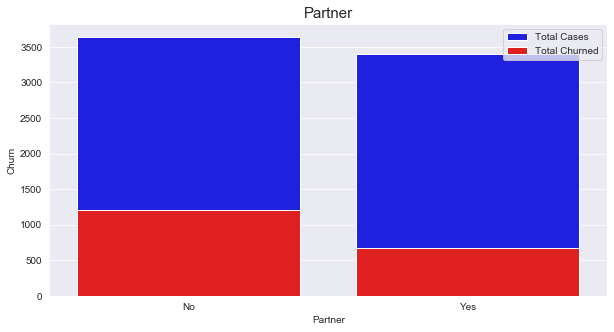

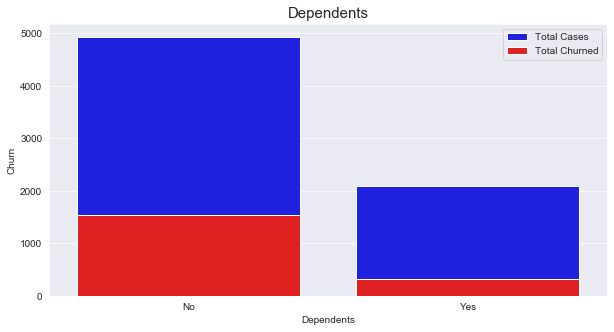

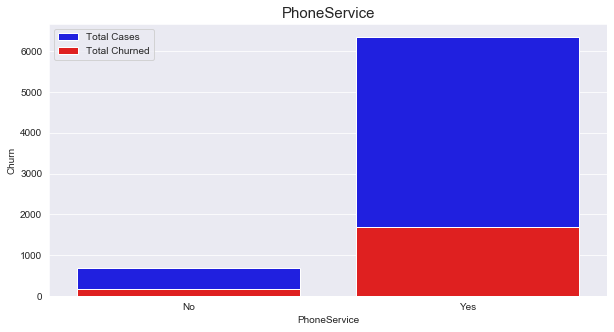

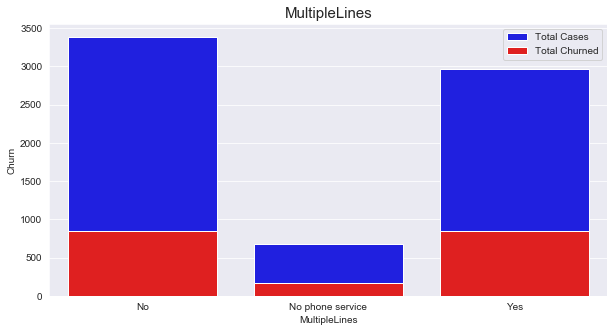

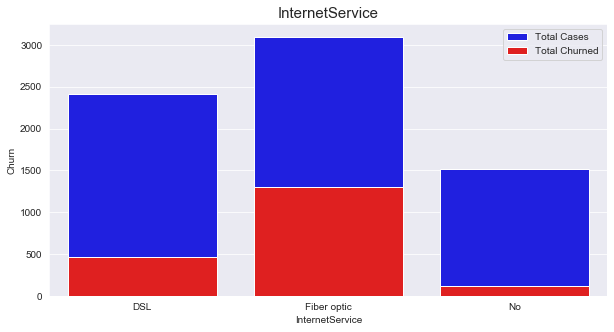

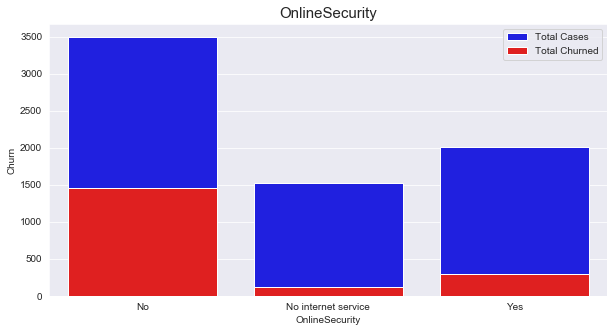

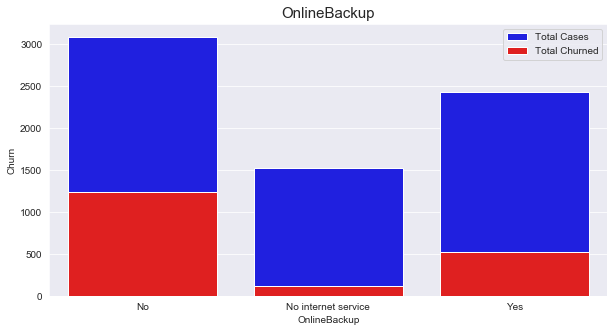

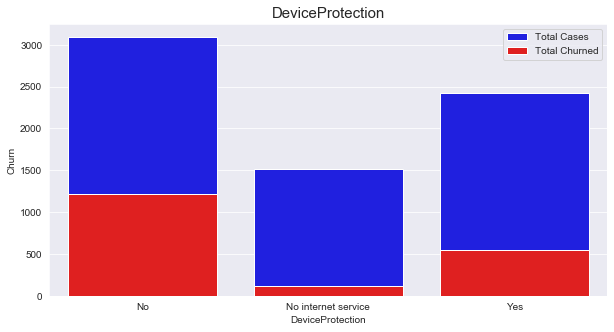

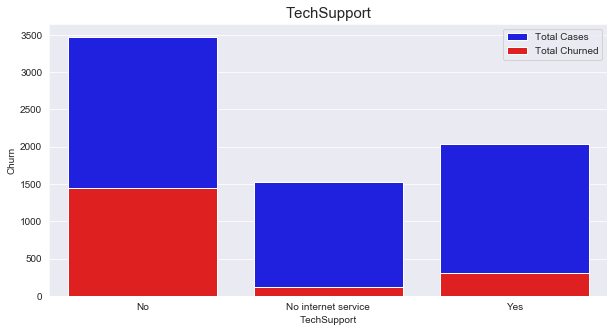

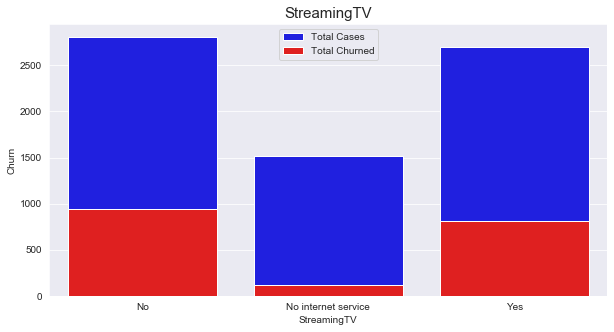

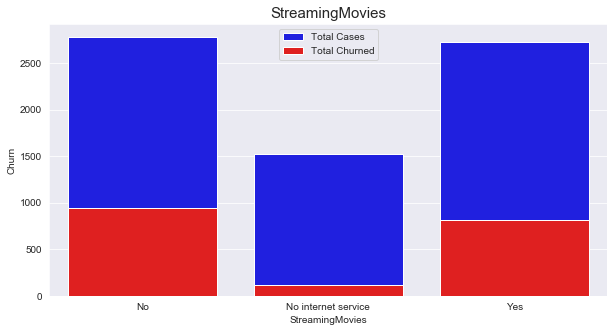

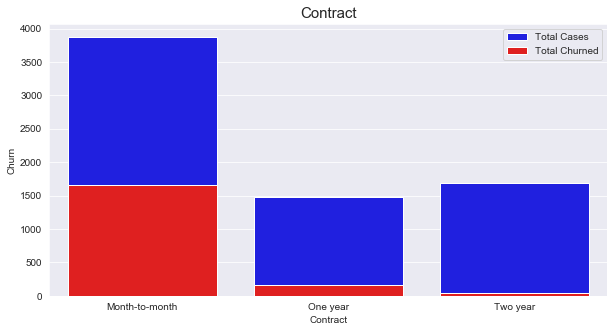

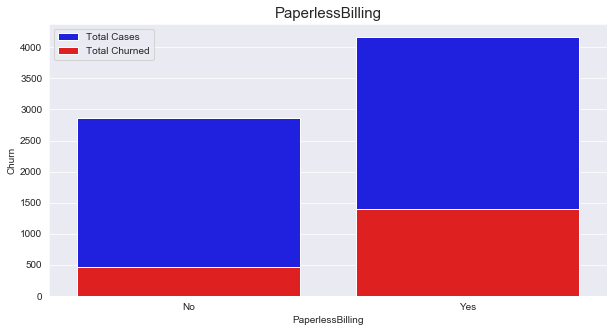

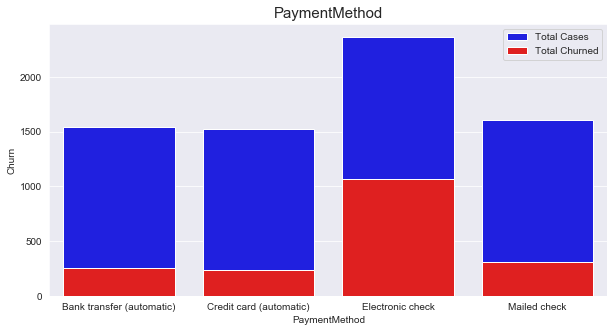

In [24]:
for col in categorical:
    quick_bar(col)

Plotted bar graphs of distribution of categorical columns

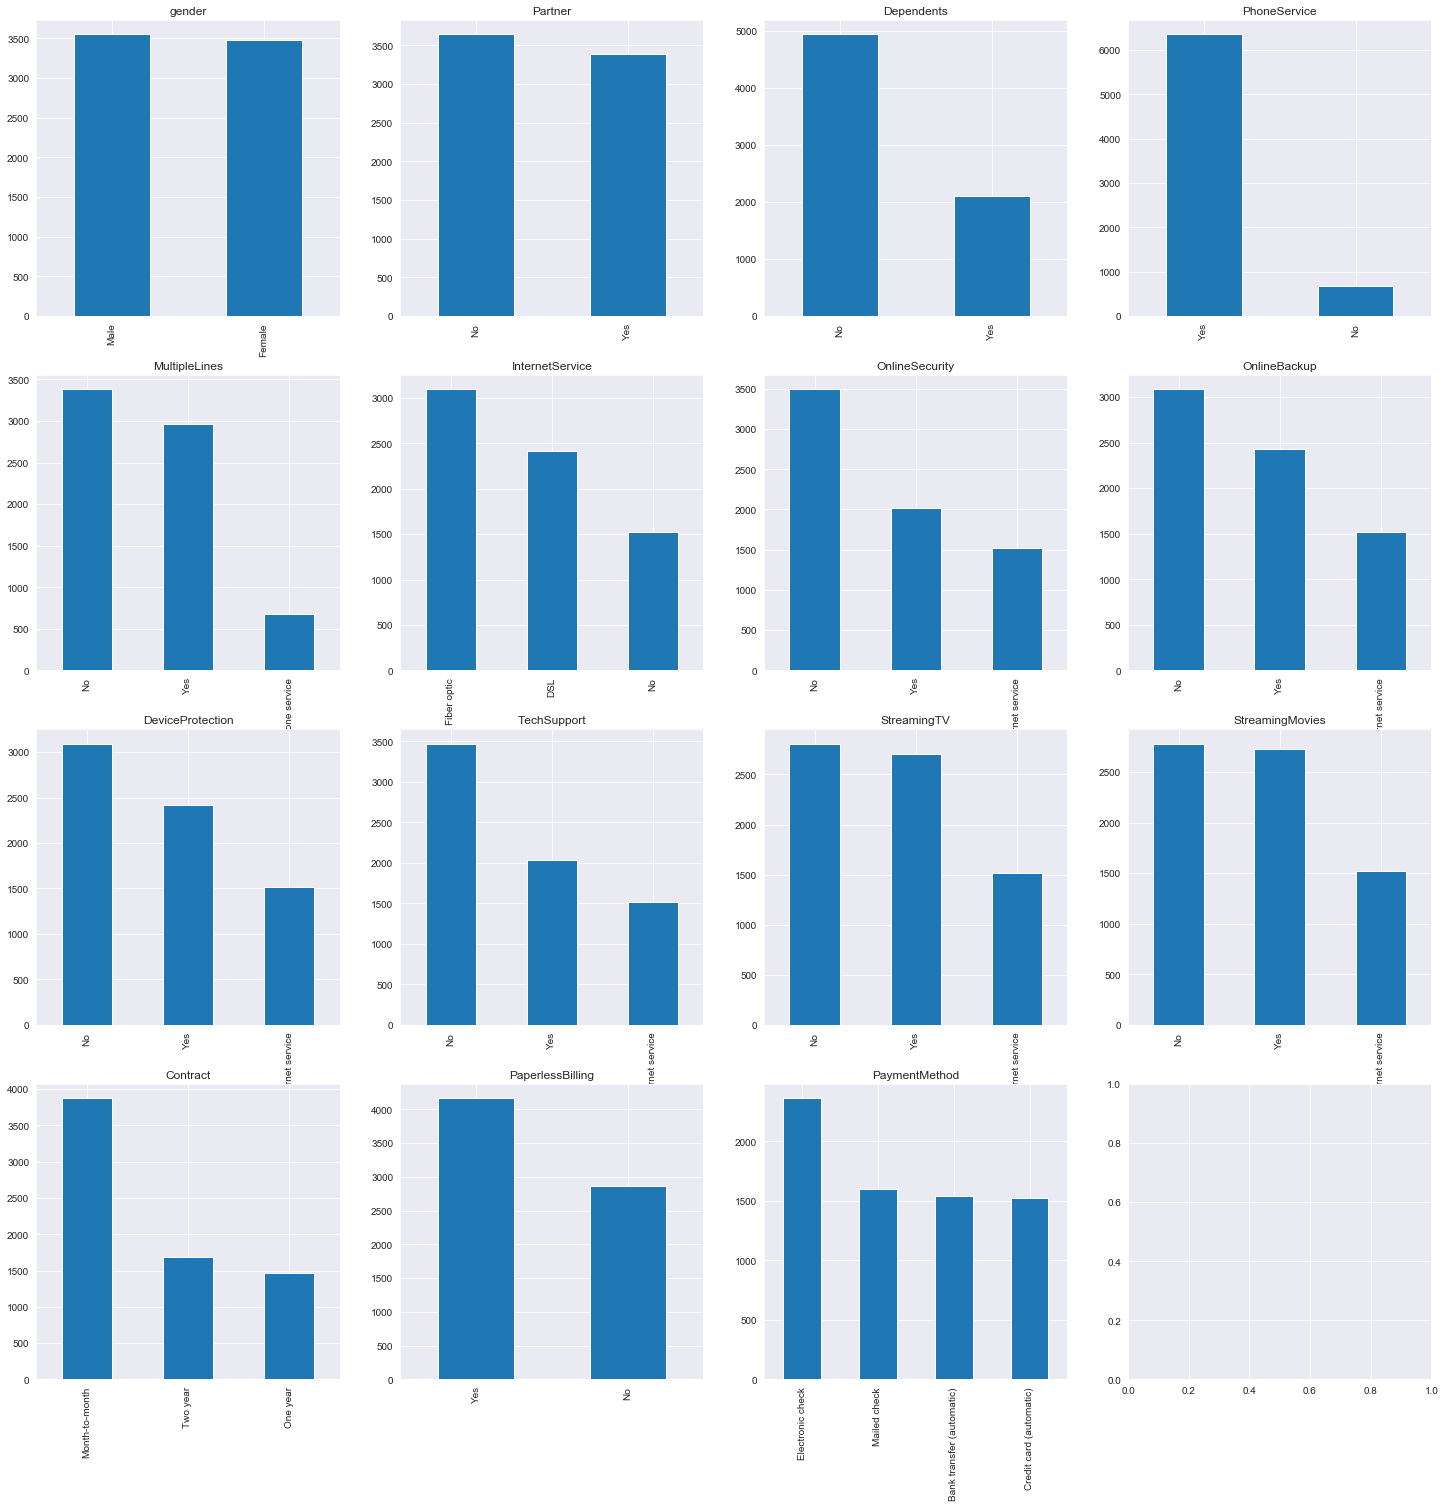

In [25]:
ROWS, COLS = 4,4
fig, ax = plt.subplots(ROWS, COLS, figsize=(25,25))
row, col = 0,0
for i, category in enumerate(categorical):
    if col == COLS - 1:
        row += 1
    col = i % COLS
    df[category].value_counts().plot(kind='bar', ax=ax[row,col]).set_title(category)

Made heatmap of the numerical columns to check for multicollinearity. Strong multicollinearity detected in Total Charges and tenure columns. Will make a note to deal with this later

tenure            2
MonthlyCharges    1
TotalCharges      2
dtype: int64


(<matplotlib.axes._subplots.AxesSubplot at 0x1a24ff2748>, None)

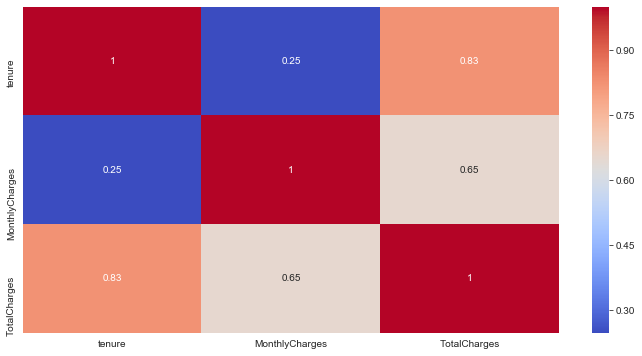

In [26]:
make_heatmap(df, numerical)

Plotted bar graph to analyze class distribution. Churn has occurred in 26.57% of cases in this data set, and not occurred in 73.42% of cases. Synthetic samples may need to be created in order to address the class imbalance

Percentage of Churn Class in Data Set is 26.58


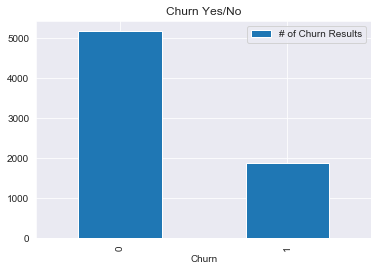

In [27]:
df.groupby('Churn').count().plot(kind='bar', y='gender', label='# of Churn Results')
plt.title('Churn Yes/No')
print('Percentage of Churn Class in Data Set is {}'.format(round(len(df.loc[df['Churn'] == 1])/len(df) * 100, 2)))

In [166]:
sns.pairplot(df[categorical])

IndexError: index -1 is out of bounds for axis 0 with size 0

<Figure size 0x0 with 0 Axes>

# Initial Modeling #

Split data set into two separate dataframes for modeling

In [29]:
y = df['Churn']
X = df.drop(columns = 'Churn', axis=1)

In [30]:
X[categorical]

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check
1,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check
2,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check
3,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic)
4,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,Yes,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check
7039,Female,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic)
7040,Female,Yes,Yes,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check
7041,Male,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check


Used pd.get_dummies on categorical columns since ML Models cannot use string columns for predictor variables

In [31]:
X=pd.get_dummies(X, drop_first = True)

In [32]:
X.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,34,56.95,1889.50,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,2,53.85,108.15,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,45,42.30,1840.75,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
4,2,70.70,151.65,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


Normalized all features in data frame to ensure that numerical features don't impact the model more than the others for the baseline model

In [33]:
X = X.fillna(value=0) 
for col in X.columns:
    X[col] = (X[col] - min(X[col]))/ (max(X[col]) - min(X[col])) 

X.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.000000,0.115423,0.001275,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.464789,0.385075,0.215867,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.014085,0.354229,0.010310,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.619718,0.239303,0.210241,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.014085,0.521891,0.015330,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


Performed train/test split on Scaled features and target to use in modeling

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

# SMOTE and Under/Over Sampling

Performed SMOTE on original data set in order to see what the effect will be on the model results

In [35]:
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

0    5163
1    1869
Name: Churn, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    3863
0    3863
dtype: int64


# Logistic Regression Model

In [36]:
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(X_train, y_train)
model_log

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
model_log.predict(X_test)

array([0, 0, 1, ..., 0, 0, 0])

In [38]:
y_score = logreg.fit(X_train, y_train).decision_function(X_test)

In [39]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.8344524689284515


AUC: 0.8344524689284515


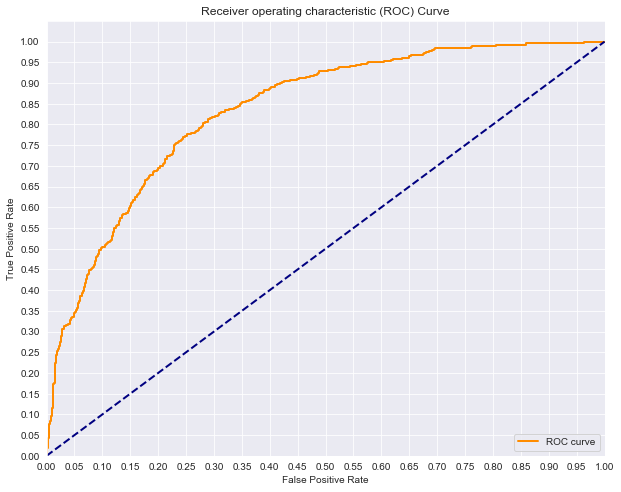

In [40]:
print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [41]:
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

In [42]:
print('Training Precision: ', precision_score(y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(y_train, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))


Training Precision:  0.6633744855967079
Testing Precision:  0.6181818181818182



Training Recall:  0.5712260807937632
Testing Recall:  0.519650655021834



Training Accuracy:  0.8077360637087599
Testing Accuracy:  0.7912400455062572



Training F1-Score:  0.6138613861386139
Testing F1-Score:  0.5646500593119811


In [43]:
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(X_train_resampled, y_train_resampled)
model_log

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
model_log.predict(X_test)
y_score = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.8347161572052402


AUC: 0.8347161572052402


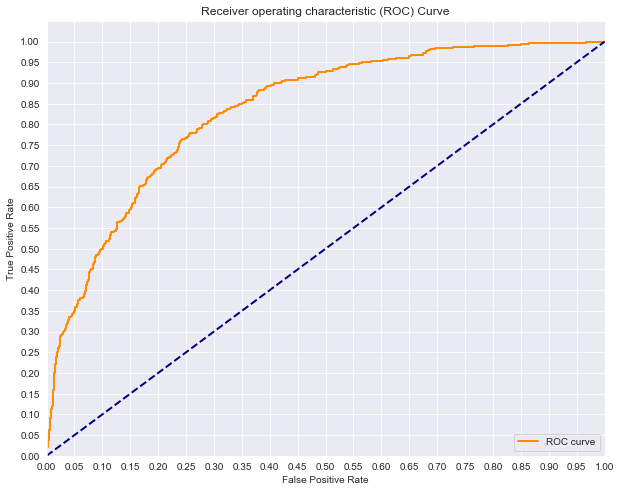

In [45]:
print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [46]:
y_hat_train = logreg.predict(X_train_resampled)
y_hat_test = logreg.predict(X_test)

In [47]:
print('Training Precision: ', precision_score(y_train_resampled, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(y_train_resampled, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train_resampled, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train_resampled, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Training Precision:  0.7616181073922466
Testing Precision:  0.5063113604488079



Training Recall:  0.818793683665545
Testing Recall:  0.7882096069868996



Training Accuracy:  0.7812580895676935
Testing Accuracy:  0.7445961319681457



Training F1-Score:  0.7891716566866268
Testing F1-Score:  0.6165670367207515


# Decision Tree Model

Decided to use Decision Tree for baseline model since they seem to be good at modeling for binary classification. Fit Decision Tree to training data and after predicting using the testing data, area under the curve percent is around 64%. Slightly better than coin toss so hyperparamter tuning must occur in order to increase model viability

Also when computing the training and test AUC and classification report, AUC for training set is almost 99% which shows significant oversampling

In [48]:
dtc = DecisionTreeClassifier(random_state=123)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [49]:
y_pred = dtc.predict(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6368995633187773

Training AUC: 0.9970356980295901


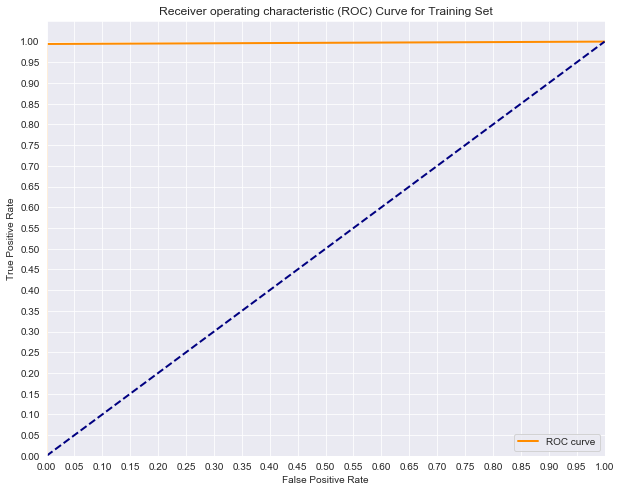

Test AUC: 0.6368995633187773



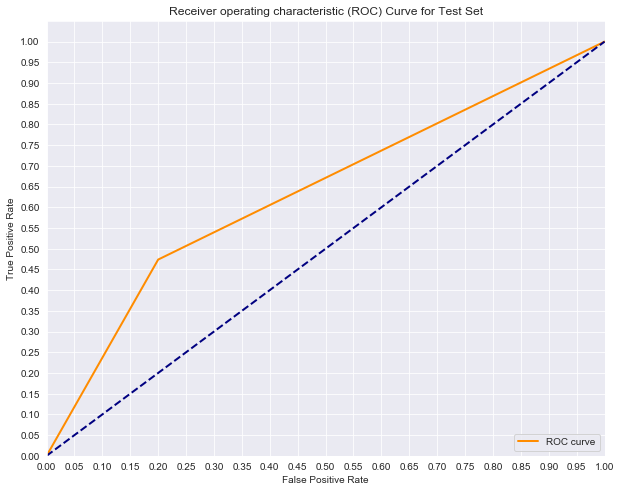

[[1040  260]
 [ 241  217]]
              precision    recall  f1-score   support

           0       0.81      0.80      0.81      1300
           1       0.45      0.47      0.46       458

    accuracy                           0.72      1758
   macro avg       0.63      0.64      0.64      1758
weighted avg       0.72      0.72      0.72      1758



In [50]:
quick_scores(X_train, X_test, y_train, y_test,model=dtc)

Ran Grid Search for criterion, max_depth, min_samples_split, min_samples_leaf parameters. Plugged in new parameters to decision tree model and re ran. Saw significant improvement in model performance, although model is still having issues identifying churned class

In [51]:
dtc = DecisionTreeClassifier()
param_grid = {
     'criterion':['gini','entropy'],
    'max_depth':[None, 2,3,4,5,6],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,3,4,5,6]
}
gs_tree = GridSearchCV(dtc, param_grid, cv=3, n_jobs=-1)
gs_tree.fit(X_train, y_train)

gs_tree.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 6,
 'min_samples_split': 2}

In [52]:
dtc = DecisionTreeClassifier(criterion='entropy', random_state=42, min_samples_leaf = 6, min_samples_split = 2, max_depth = 6)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [53]:
y_pred = dtc.predict(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7134077930802821

Training AUC: 0.7553118475026939


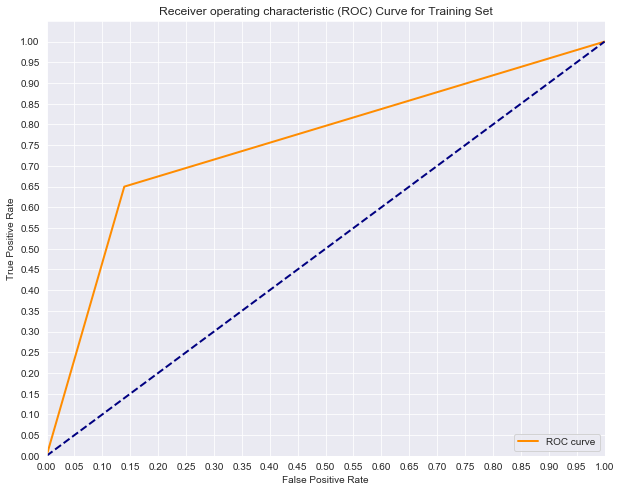

Test AUC: 0.7134077930802821



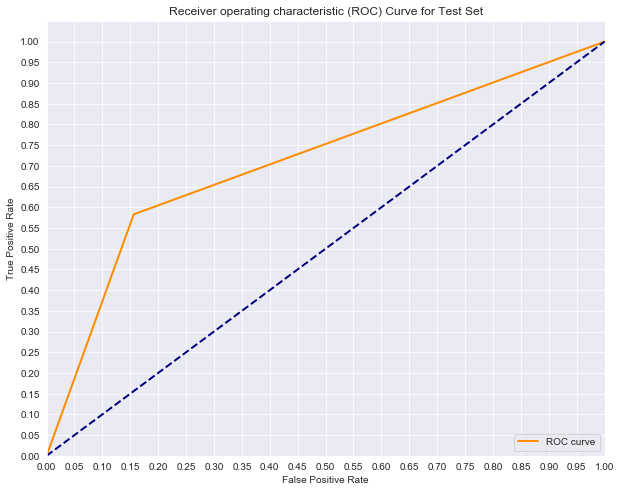

[[1097  203]
 [ 191  267]]
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1300
           1       0.57      0.58      0.58       458

    accuracy                           0.78      1758
   macro avg       0.71      0.71      0.71      1758
weighted avg       0.78      0.78      0.78      1758



In [54]:
quick_scores(X_train, X_test, y_train, y_test,model=dtc)

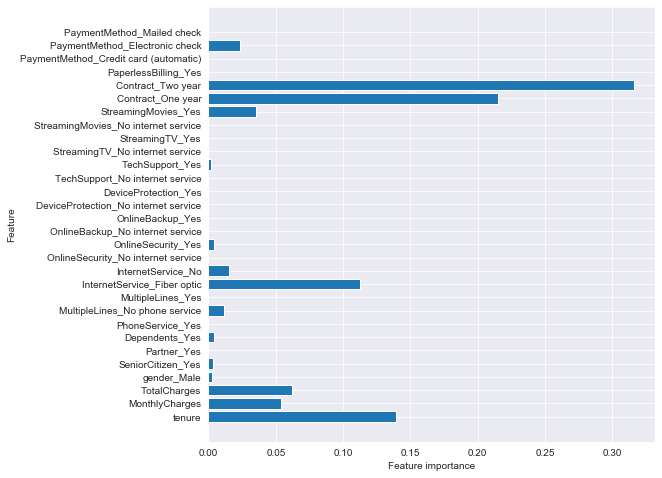

In [55]:
plot_feature_importances(dtc)

In [56]:
dtc = DecisionTreeClassifier(criterion='entropy', random_state=42, min_samples_leaf = 6, min_samples_split = 2, max_depth = 6)
dtc.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [57]:
y_pred = dtc.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7368357406785354

Training AUC: 0.7944602640434896


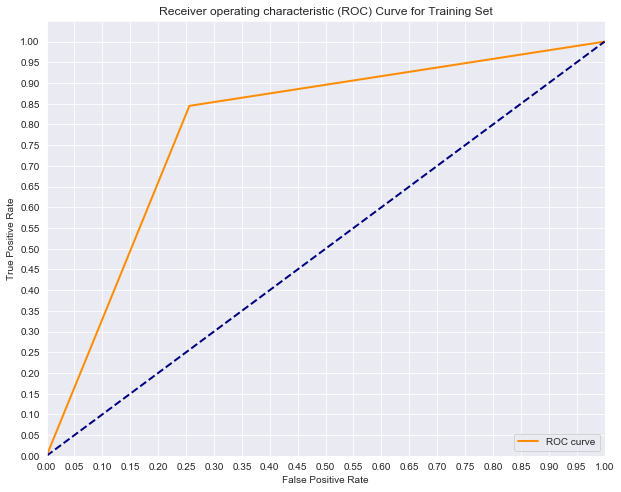

Test AUC: 0.7368357406785354



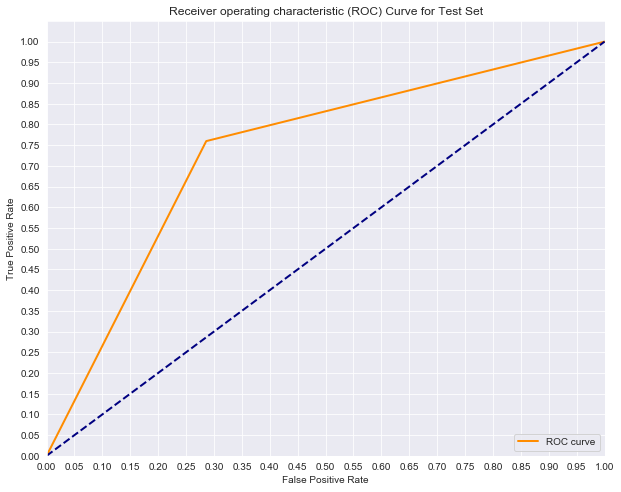

[[928 372]
 [110 348]]
              precision    recall  f1-score   support

           0       0.89      0.71      0.79      1300
           1       0.48      0.76      0.59       458

    accuracy                           0.73      1758
   macro avg       0.69      0.74      0.69      1758
weighted avg       0.79      0.73      0.74      1758



In [58]:
quick_scores(X_train_resampled, X_test, y_train_resampled, y_test,model=dtc)

In [59]:
y_hat_train = dtc.predict(X_train_resampled)
y_hat_test = dtc.predict(X_test)

In [60]:
print('Training Precision: ', precision_score(y_train_resampled, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(y_train_resampled, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train_resampled, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train_resampled, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Training Precision:  0.7674582647542911
Testing Precision:  0.48333333333333334



Training Recall:  0.8449391664509449
Testing Recall:  0.759825327510917



Training Accuracy:  0.7944602640434895
Testing Accuracy:  0.7258248009101251



Training F1-Score:  0.8043371118777723
Testing F1-Score:  0.5908319185059423


# Bagged Tree Ensemble Model

In [61]:
bagged_tree = BaggingClassifier(DecisionTreeClassifier(criterion='entropy', random_state=42, min_samples_leaf = 6, min_samples_split = 2, max_depth = 6), n_estimators = 20)

In [62]:
bagged_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='entropy',
                                                        max_depth=6,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=6,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=42,
                                                        splitter='best'),
      

Training AUC: 0.7461957589612918


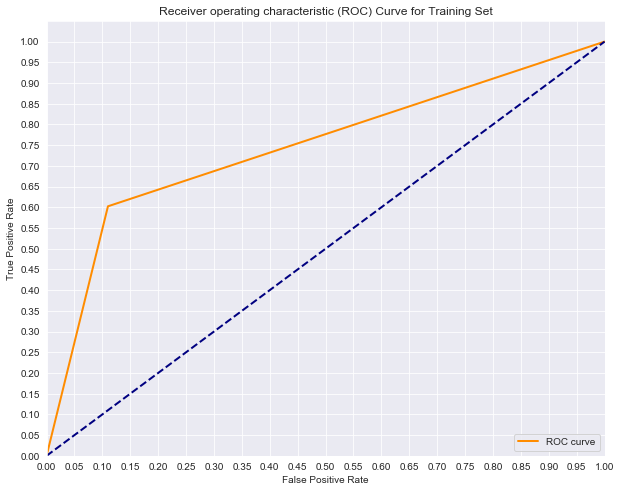

Test AUC: 0.7069583473295263



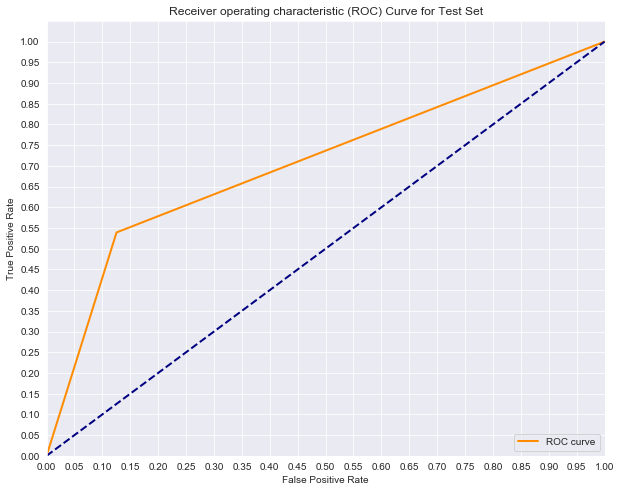

[[1137  163]
 [ 211  247]]
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1300
           1       0.60      0.54      0.57       458

    accuracy                           0.79      1758
   macro avg       0.72      0.71      0.71      1758
weighted avg       0.78      0.79      0.78      1758



In [63]:
quick_scores(X_train, X_test, y_train, y_test,model = bagged_tree)

In [64]:
y_pred = bagged_tree.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1137  163]
 [ 211  247]]
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1300
           1       0.60      0.54      0.57       458

    accuracy                           0.79      1758
   macro avg       0.72      0.71      0.71      1758
weighted avg       0.78      0.79      0.78      1758



In [65]:
bagged_tree.score(X_train, y_train)

0.8130451270383011

In [66]:
bagged_tree.score(X_test, y_test)

0.7872582480091013

In [67]:
bagged_tree.fit(X_train_resampled, y_train_resampled)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='entropy',
                                                        max_depth=6,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=6,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=42,
                                                        splitter='best'),
      

Training AUC: 0.8026145482785398


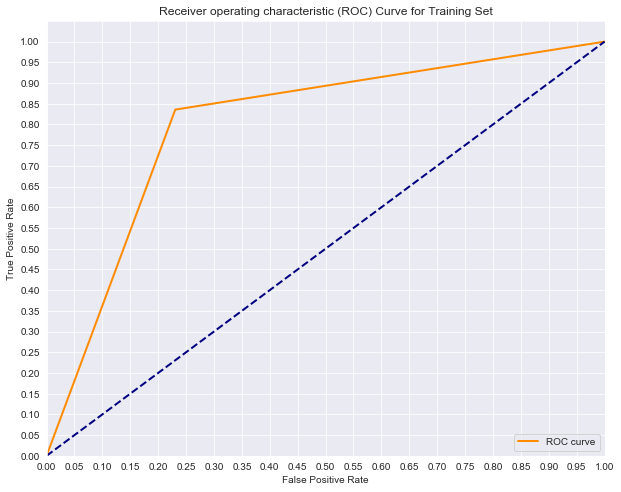

Test AUC: 0.7382264024185422



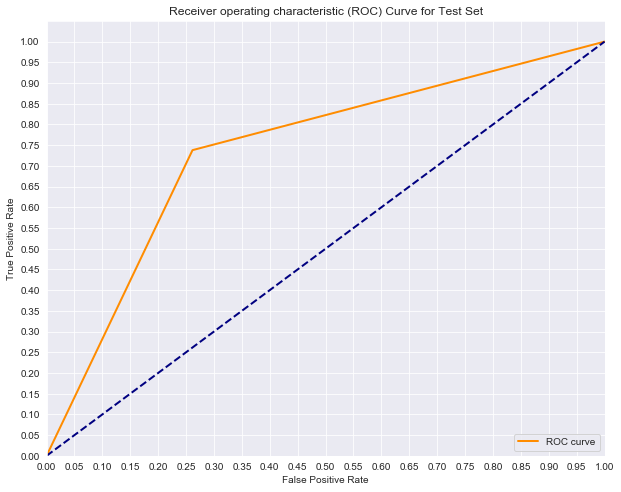

[[960 340]
 [120 338]]
              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1300
           1       0.50      0.74      0.60       458

    accuracy                           0.74      1758
   macro avg       0.69      0.74      0.70      1758
weighted avg       0.79      0.74      0.75      1758



In [68]:
quick_scores(X_train_resampled, X_test, y_train_resampled, y_test,model = bagged_tree)

In [69]:
y_hat_train = bagged_tree.predict(X_train_resampled)
y_hat_test = bagged_tree.predict(X_test)

In [70]:
print('Training Precision: ', precision_score(y_train_resampled, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(y_train_resampled, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train_resampled, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train_resampled, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Training Precision:  0.7837378640776699
Testing Precision:  0.49852507374631266



Training Recall:  0.8358788506342221
Testing Recall:  0.7379912663755459



Training Accuracy:  0.80261454827854
Testing Accuracy:  0.7383390216154722



Training F1-Score:  0.8089690592509081
Testing F1-Score:  0.5950704225352113


# Random Forest Classification Model

In [71]:
forest = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42, min_samples_leaf = 6, min_samples_split = 2, max_depth = 6)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Training AUC: 0.7145364818748736


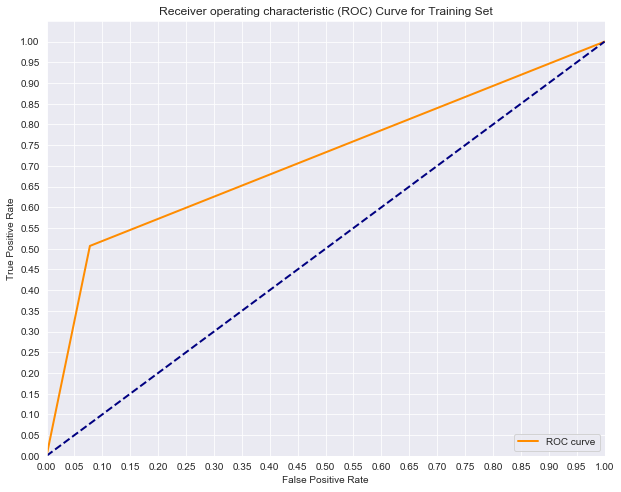

Test AUC: 0.6746187437017132



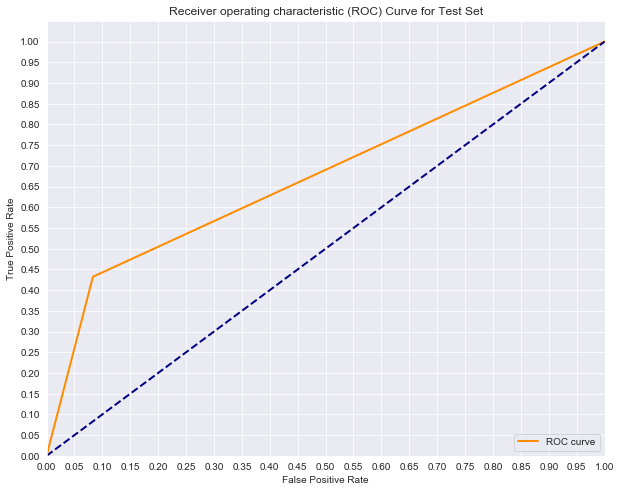

[[1192  108]
 [ 260  198]]
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1300
           1       0.65      0.43      0.52       458

    accuracy                           0.79      1758
   macro avg       0.73      0.67      0.69      1758
weighted avg       0.78      0.79      0.78      1758



In [72]:
quick_scores(X_train, X_test, y_train, y_test,model=forest)

In [73]:
forest.score(X_train, y_train)

0.8111490329920364

In [74]:
forest.score(X_test, y_test)

0.7906712172923777

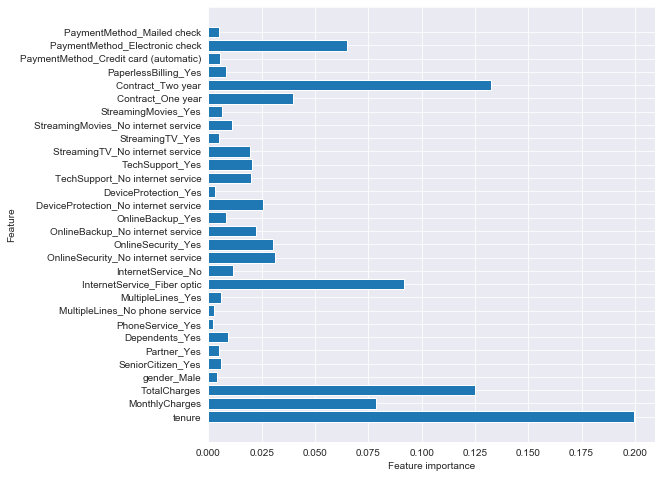

In [75]:
plot_feature_importances(forest)

In [76]:
forest = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42, min_samples_leaf = 6, min_samples_split = 2, max_depth = 6)
forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Training AUC: 0.818664250582449


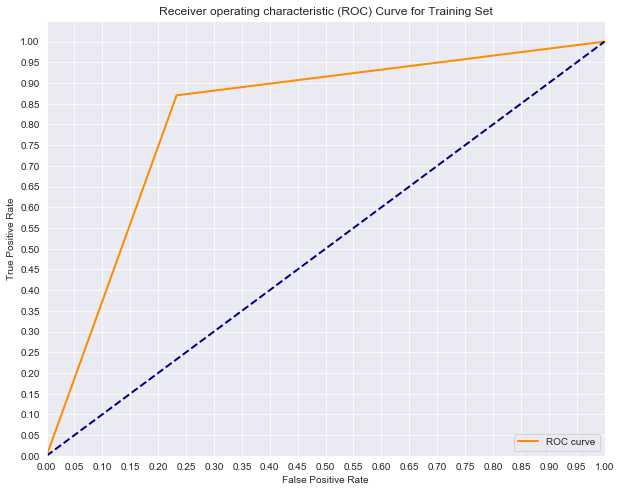

Test AUC: 0.754217332885455



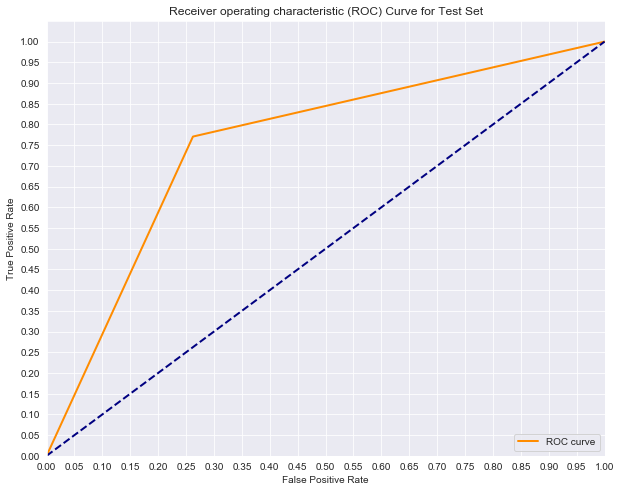

[[959 341]
 [105 353]]
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1300
           1       0.51      0.77      0.61       458

    accuracy                           0.75      1758
   macro avg       0.70      0.75      0.71      1758
weighted avg       0.80      0.75      0.76      1758



In [77]:
quick_scores(X_train_resampled, X_test, y_train_resampled, y_test,model=forest)

In [78]:
y_hat_train = forest.predict(X_train_resampled)
y_hat_test = forest.predict(X_test)

In [79]:
print('Training Precision: ', precision_score(y_train_resampled, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(y_train_resampled, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train_resampled, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train_resampled, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Training Precision:  0.7888315344908494
Testing Precision:  0.5086455331412104



Training Recall:  0.8703080507377686
Testing Recall:  0.7707423580786026



Training Accuracy:  0.8186642505824488
Testing Accuracy:  0.7463026166097838



Training F1-Score:  0.8275692307692308
Testing F1-Score:  0.6128472222222223


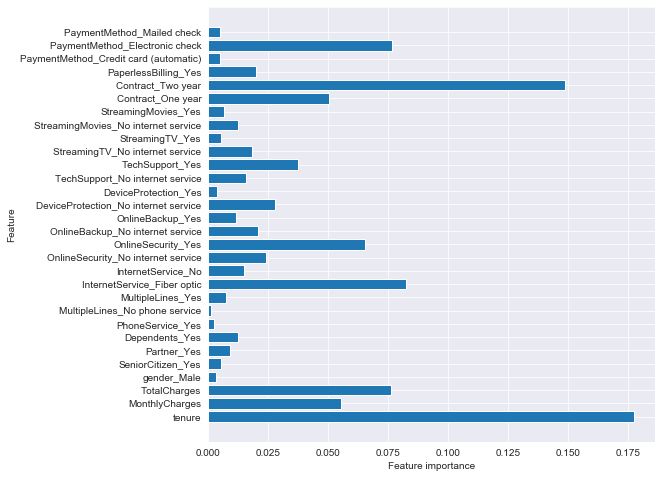

In [80]:
plot_feature_importances(forest)

# XGBoosted Classifier Model

In [81]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [82]:
training_preds = xgb_clf.predict(X_train)
val_preds = xgb_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 82.48%
Validation accuracy: 79.18%


Training AUC: 0.7494971740290639


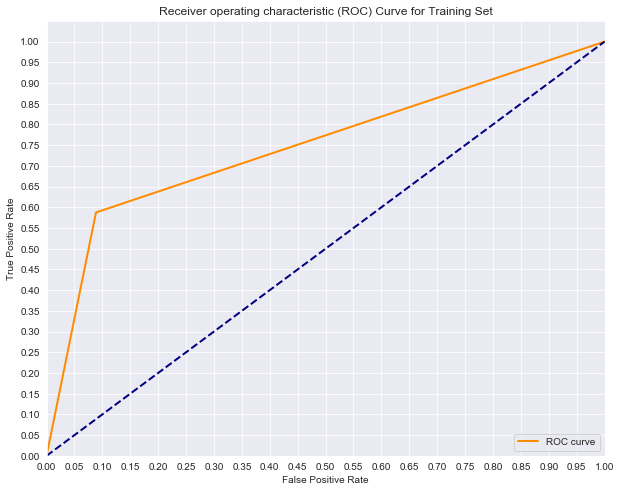

Test AUC: 0.6951864292912328



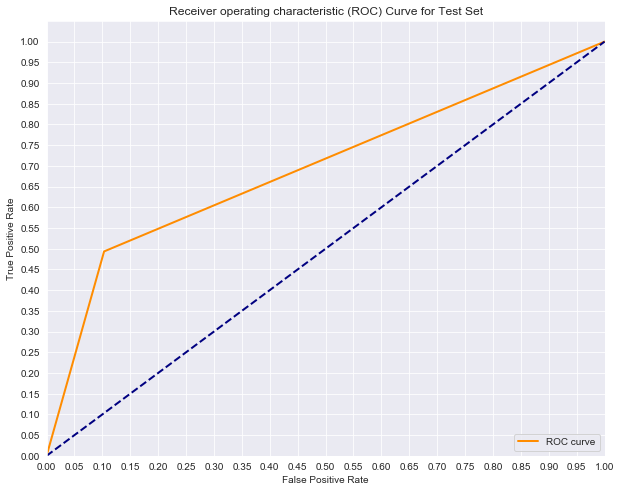

[[1166  134]
 [ 232  226]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1300
           1       0.63      0.49      0.55       458

    accuracy                           0.79      1758
   macro avg       0.73      0.70      0.71      1758
weighted avg       0.78      0.79      0.78      1758



In [83]:
quick_scores(X_train, X_test, y_train, y_test, xgb_clf)

In [84]:
param_grid = {
    "learning_rate": [0.1,0.01,0.001],
    'max_depth': [1, 5, 10],
    'min_child_weight': [1,5,10],
    'subsample': [0.5,0.6,0.7],
    'n_estimators': [5, 30, 100, 250],
}

In [85]:
grid_clf = GridSearchCV(xgb_clf, param_grid, scoring='accuracy', cv=None, n_jobs=-1)
grid_clf.fit(X, y)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

/Users/will4856/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 1
min_child_weight: 5
n_estimators: 250
subsample: 0.6

Training Accuracy: 81.3%
Validation accuracy: 79.64%


In [88]:
plot_feature_importances(grid_clf)

AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

<Figure size 576x576 with 0 Axes>

In [210]:
clf = xgb.XGBClassifier(learning_rate=0.1, max_depth=1, min_child_weight=5, n_estimators=250, subsample=0.6)
clf.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=1,
              min_child_weight=5, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)

In [212]:
quick_scores(X_train_resampled, X_test, y_train_resampled, y_test, clf)

ValueError: feature_names must be unique

In [213]:
training_preds = clf.predict(X_train)
val_preds = clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

ValueError: feature_names must be unique

In [ ]:
clf = xgb.XGBClassifier(learning_rate=0.1, max_depth=1, min_child_weight=5, n_estimators=250, subsample=0.6)
clf.fit(X_train_resampled, y_train_resampled)

In [ ]:
y_hat_train = clf.predict(X_train_resampled)
y_hat_test = clf.predict(X_test)

# KNN Model

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

In [ ]:
y_pred = knn_clf.predict(X_test)

In [89]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))
    
print_metrics(y_test, y_pred)

Precision Score: 0.6024390243902439
Recall Score: 0.5393013100436681
Accuracy Score: 0.7872582480091013
F1 Score: 0.5691244239631336


In [90]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=30):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds)
        if f1 > best_score:
            best_k = k
            best_score = f1
    
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))


In [91]:
find_best_k(X_train,y_train, X_test, y_test)

Best Value for k: 29
F1-Score: 0.5793562708102109


In [92]:
knn_clf = KNeighborsClassifier(n_neighbors=29)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=29, p=2,
                     weights='uniform')

In [93]:
y_pred = knn_clf.predict(X_test)

In [94]:
print_metrics(y_test, y_pred)

Precision Score: 0.5891647855530474
Recall Score: 0.5698689956331878
Accuracy Score: 0.7844141069397043
F1 Score: 0.5793562708102109


In [95]:
knn_clf = KNeighborsClassifier(n_neighbors=29)
knn_clf.fit(X_train_resampled, y_train_resampled)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=29, p=2,
                     weights='uniform')

In [96]:
y_pred = knn_clf.predict(X_test)

In [97]:
print_metrics(y_test, y_pred)

Precision Score: 0.4374295377677565
Recall Score: 0.8471615720524017
Accuracy Score: 0.6763367463026166
F1 Score: 0.5769516728624536


# Support Vector Machine

In [146]:
svm_clf = SVC(kernel='linear')
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [147]:
svm_clf.coef_

array([[-1.666784  , -0.27061241, -0.9374917 , -0.01781154,  0.21352594,
         0.09202705, -0.15266964, -0.19545269,  0.19545269,  0.19947048,
         1.33696406, -0.04434236, -0.04434236, -0.29753581, -0.04434236,
        -0.06428648, -0.04434236,  0.03287083, -0.04434236, -0.26595196,
        -0.04434236,  0.18530997, -0.04434236,  0.29146736, -0.37595317,
        -0.14862349,  0.14683102, -0.13236062,  0.22148931, -0.01720279]])

In [117]:
y_preds = svm_clf.predict(X_test)
y_hat_train = svm_clf.predict(X_train)
y_hat_test = svm_clf.predict(X_test)

In [118]:
print('Training Precision: ', precision_score(y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(y_train, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Training Precision:  0.6525704809286899
Testing Precision:  0.6272493573264781



Training Recall:  0.5577604535790219
Testing Recall:  0.5327510917030568



Training Accuracy:  0.8022373909745923
Testing Accuracy:  0.7957906712172924



Training F1-Score:  0.6014520443255635
Testing F1-Score:  0.5761511216056671


In [125]:
svm_clf.fit(X_train_resampled, y_train_resampled)
y_preds = svm_clf.predict(X_test)
y_hat_train = svm_clf.predict(X_train_resampled)
y_hat_test = svm_clf.predict(X_test)

In [126]:
print('Training Precision: ', precision_score(y_train_resampled, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(y_train_resampled, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train_resampled, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train_resampled, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Training Precision:  0.7965650701499758
Testing Precision:  0.5113464447806354



Training Recall:  0.8524462852705151
Testing Recall:  0.7379912663755459



Training Accuracy:  0.8173699197514884
Testing Accuracy:  0.7480091012514221



Training F1-Score:  0.823558834562961
Testing F1-Score:  0.6041108132260948


Training AUC: 0.8173699197514885


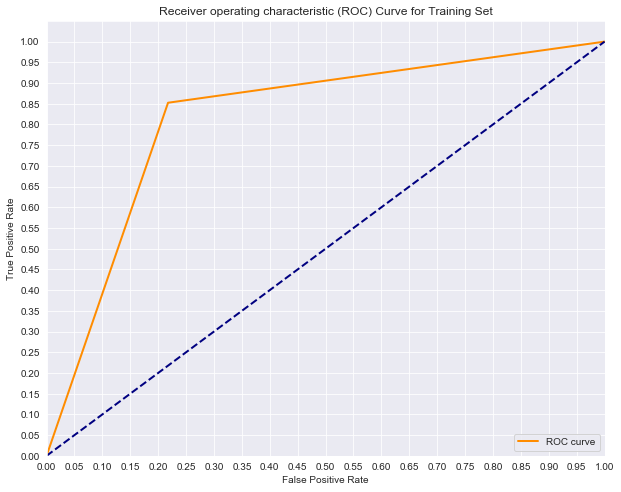

Test AUC: 0.7447648639570037



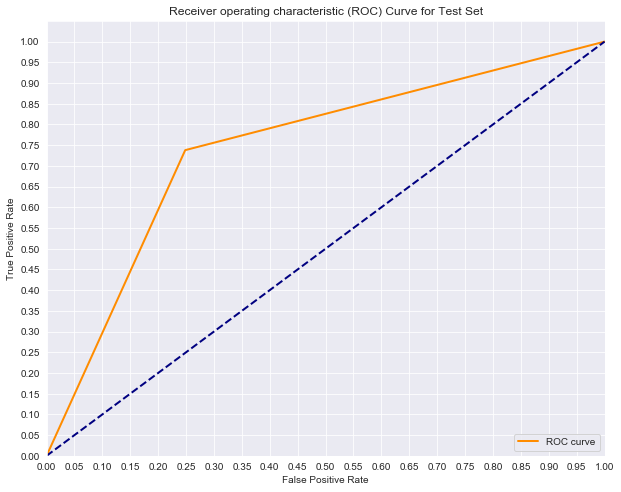

[[977 323]
 [120 338]]
              precision    recall  f1-score   support

           0       0.89      0.75      0.82      1300
           1       0.51      0.74      0.60       458

    accuracy                           0.75      1758
   macro avg       0.70      0.74      0.71      1758
weighted avg       0.79      0.75      0.76      1758



In [127]:
quick_scores(X_train_resampled, X_test, y_train_resampled, y_test, svm_clf)

In [128]:
svm_clf = SVC(kernel='rbf', gamma=0.1)
svm_clf.fit(X_train_resampled, y_train_resampled)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [129]:
y_preds = svm_clf.predict(X_test)
y_hat_train = svm_clf.predict(X_train)
y_hat_test = svm_clf.predict(X_test)

In [130]:
print('Training Precision: ', precision_score(y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(y_train, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Training Precision:  0.5684966649563878
Testing Precision:  0.5113464447806354



Training Recall:  0.7852586817859674
Testing Recall:  0.7379912663755459



Training Accuracy:  0.783086841107319
Testing Accuracy:  0.7480091012514221



Training F1-Score:  0.6595238095238094
Testing F1-Score:  0.6041108132260948


Training AUC: 0.8173699197514885


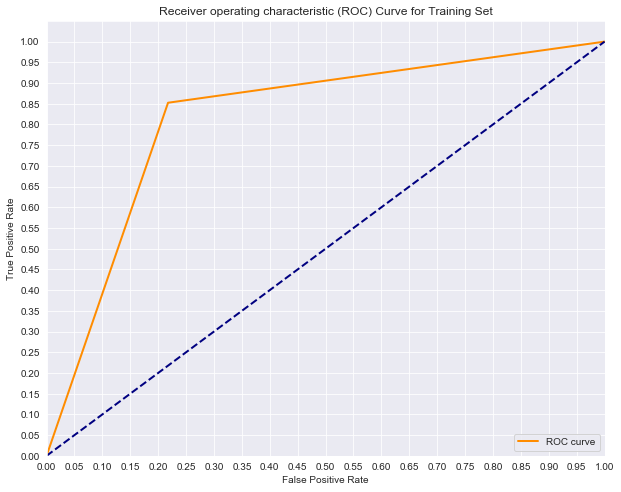

Test AUC: 0.7447648639570037



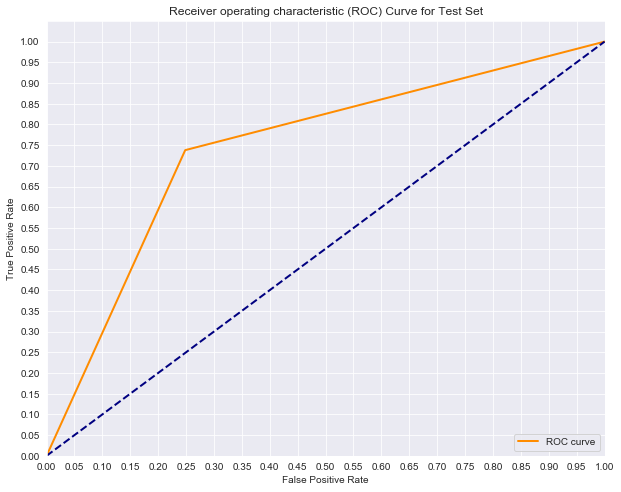

[[977 323]
 [120 338]]
              precision    recall  f1-score   support

           0       0.89      0.75      0.82      1300
           1       0.51      0.74      0.60       458

    accuracy                           0.75      1758
   macro avg       0.70      0.74      0.71      1758
weighted avg       0.79      0.75      0.76      1758



In [131]:
quick_scores(X_train_resampled, X_test, y_train_resampled, y_test, svm_clf)

In [141]:
svm_clf = SVC(kernel='poly', gamma=0.1)
svm_clf.fit(X_train_resampled, y_train_resampled)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [142]:
y_preds = svm_clf.predict(X_test)
y_hat_train = svm_clf.predict(X_train_resampled)
y_hat_test = svm_clf.predict(X_test)
print('Training Precision: ', precision_score(y_train_resampled, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(y_train_resampled, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train_resampled, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train_resampled, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Training Precision:  0.7649621646411373
Testing Precision:  0.48590604026845635



Training Recall:  0.8635775304167745
Testing Recall:  0.7903930131004366



Training Accuracy:  0.799119855034947
Testing Accuracy:  0.7275312855517634



Training F1-Score:  0.8112840466926069
Testing F1-Score:  0.6018287614297589


Training AUC: 0.799119855034947


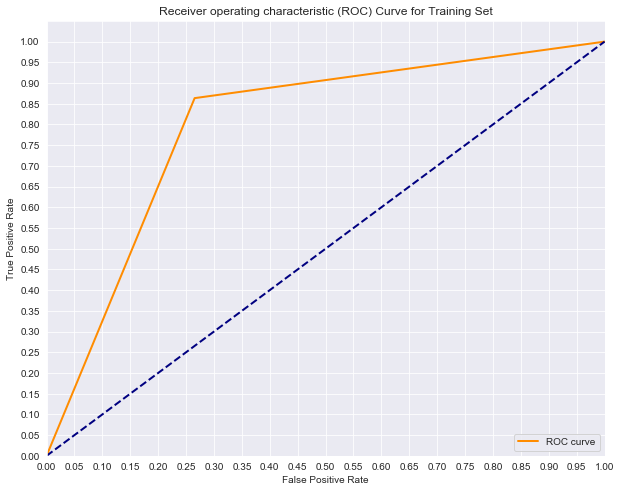

Test AUC: 0.747888814242526



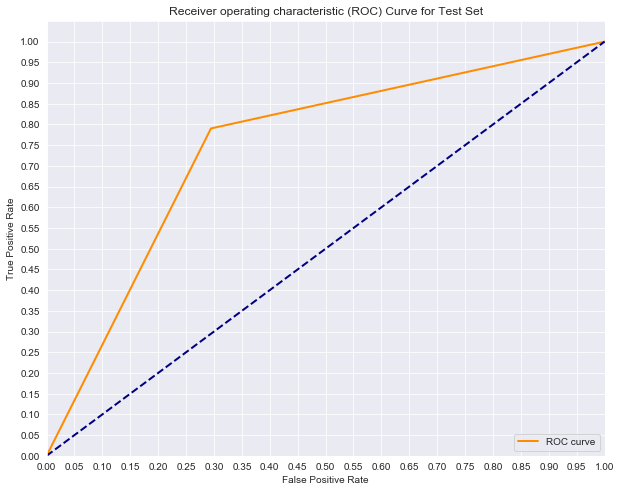

[[917 383]
 [ 96 362]]
              precision    recall  f1-score   support

           0       0.91      0.71      0.79      1300
           1       0.49      0.79      0.60       458

    accuracy                           0.73      1758
   macro avg       0.70      0.75      0.70      1758
weighted avg       0.80      0.73      0.74      1758



In [143]:
quick_scores(X_train_resampled, X_test, y_train_resampled, y_test, svm_clf)

In [145]:
svm_clf.coef_

AttributeError: coef_ is only available when using a linear kernel

In [135]:
svm_clf = SVC(kernel='sigmoid', gamma=0.1)
svm_clf.fit(X_train_resampled, y_train_resampled)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [136]:
y_preds = svm_clf.predict(X_test)
y_hat_train = svm_clf.predict(X_train_resampled)
y_hat_test = svm_clf.predict(X_test)
print('Training Precision: ', precision_score(y_train_resampled, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(y_train_resampled, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train_resampled, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train_resampled, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Training Precision:  0.6688144329896907
Testing Precision:  0.41970310391363025



Training Recall:  0.6717577012684443
Testing Recall:  0.6790393013100436



Training Accuracy:  0.6695573388558116
Testing Accuracy:  0.6717861205915814



Training F1-Score:  0.6702828361100349
Testing F1-Score:  0.5187656380316932


Training AUC: 0.6695573388558115


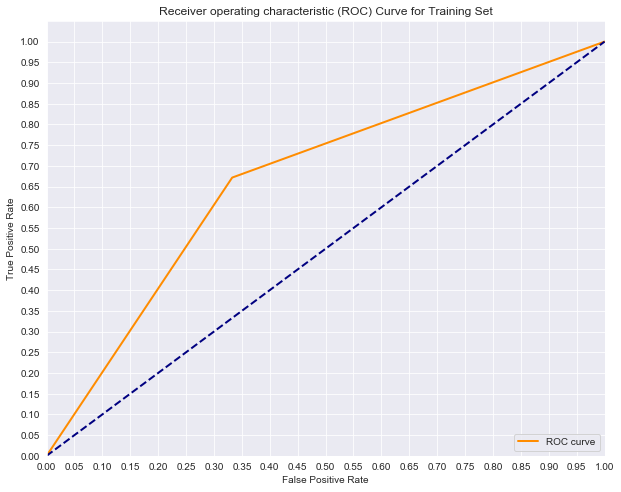

Test AUC: 0.6741350352704065



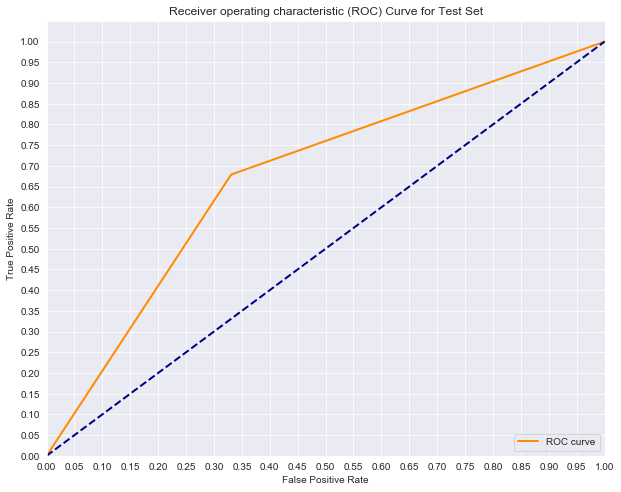

[[870 430]
 [147 311]]
              precision    recall  f1-score   support

           0       0.86      0.67      0.75      1300
           1       0.42      0.68      0.52       458

    accuracy                           0.67      1758
   macro avg       0.64      0.67      0.63      1758
weighted avg       0.74      0.67      0.69      1758



In [137]:
quick_scores(X_train_resampled, X_test, y_train_resampled, y_test, svm_clf)

In [167]:
svm_clf = SVC(kernel='poly', gamma=0.1)
svm_clf.fit(X_train_resampled, y_train_resampled)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [170]:
svm_clf = SVC(kernel='linear')
svm_clf.fit(X_train_resampled, y_train_resampled)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text yticklabel objects>)

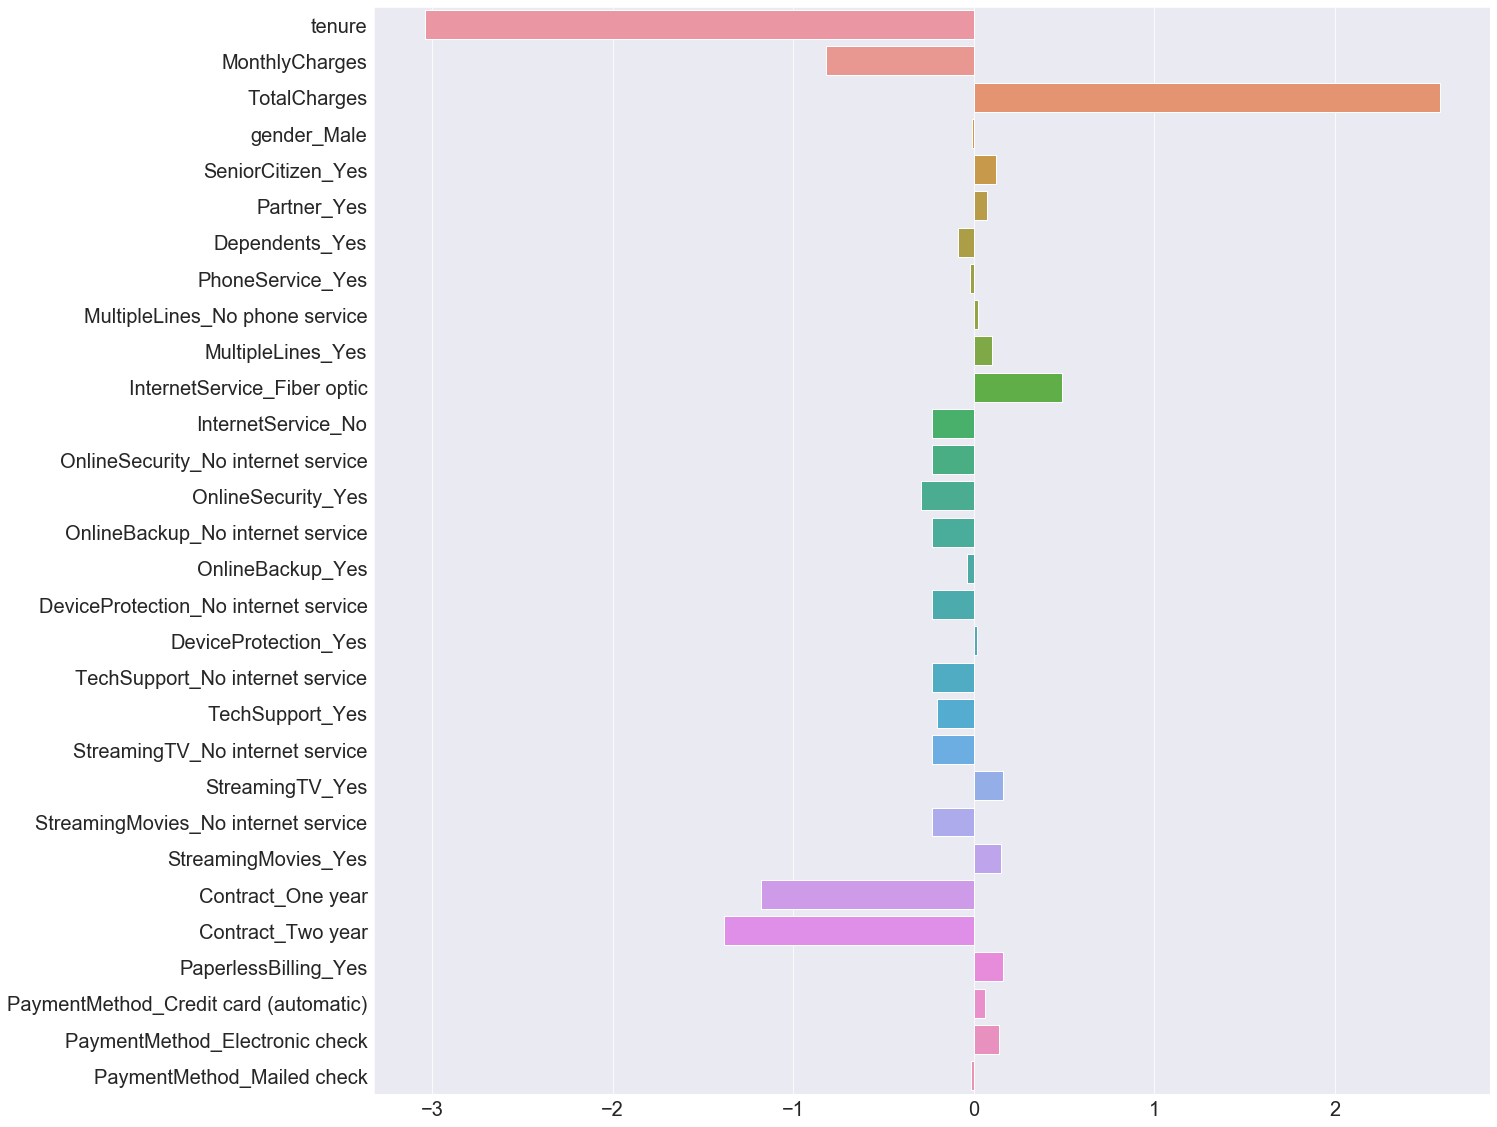

In [195]:
df_features=pd.DataFrame(svm_clf.coef_, columns=X.columns)
fig, ax = plt.subplots(figsize=(20,20))
ax1 = sns.barplot(data = df_features, orient='h')
plt.xticks(size=20)
plt.yticks(size=20)

In [199]:
X=X[['tenure','MonthlyCharges','TotalCharges','InternetService_Fiber optic','InternetService_No','OnlineSecurity_No internet service','OnlineSecurity_Yes', 'OnlineBackup_No internet service',
  'DeviceProtection_No internet service','TechSupport_No internet service',
       'TechSupport_Yes', 'StreamingTV_No internet service','TechSupport_No internet service',
       'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check']]

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [203]:
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

0    5163
1    1869
Name: Churn, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    3863
0    3863
dtype: int64


In [204]:
svm_clf = SVC(kernel='poly', gamma=0.1)
svm_clf.fit(X_train_resampled, y_train_resampled)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [205]:
y_preds = svm_clf.predict(X_test)
y_hat_train = svm_clf.predict(X_train_resampled)
y_hat_test = svm_clf.predict(X_test)
print('Training Precision: ', precision_score(y_train_resampled, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(y_train_resampled, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train_resampled, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train_resampled, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Training Precision:  0.7230871886120996
Testing Precision:  0.45465686274509803



Training Recall:  0.8415739062904478
Testing Recall:  0.8100436681222707



Training Accuracy:  0.759642764690655
Testing Accuracy:  0.6973833902161547



Training F1-Score:  0.7778442397415959
Testing F1-Score:  0.5824175824175825


Training AUC: 0.759642764690655


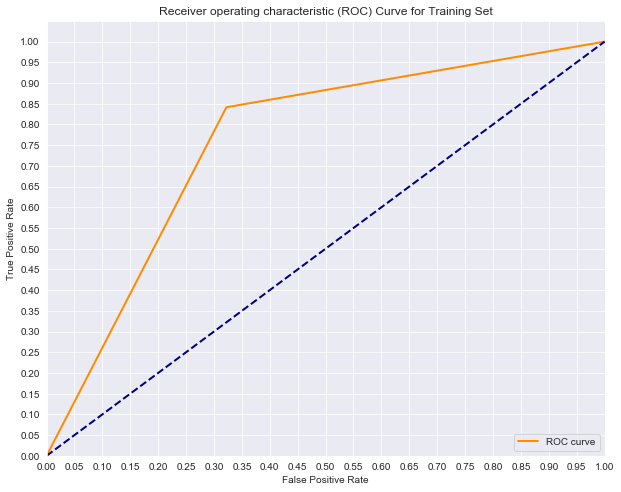

Test AUC: 0.7338679879072891



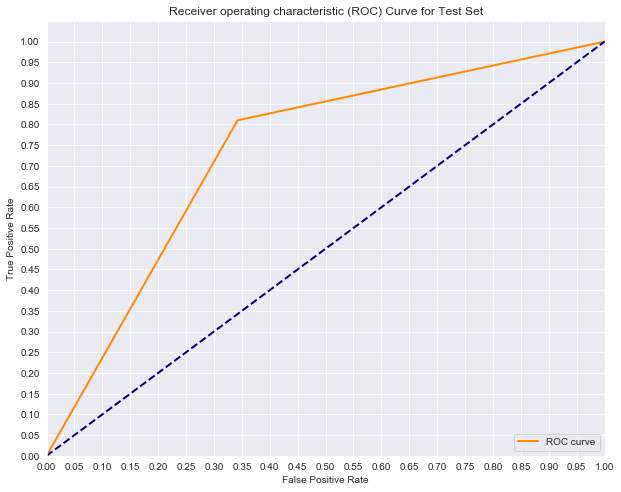

[[855 445]
 [ 87 371]]
              precision    recall  f1-score   support

           0       0.91      0.66      0.76      1300
           1       0.45      0.81      0.58       458

    accuracy                           0.70      1758
   macro avg       0.68      0.73      0.67      1758
weighted avg       0.79      0.70      0.72      1758



In [207]:
quick_scores(X_train_resampled, X_test, y_train_resampled, y_test, svm_clf)

In [208]:
len(X.columns)

23

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],                 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],                'kernel': ['linear']}